In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pydantic import BaseModel

import statsmodels.formula.api as sm
import scipy.stats as stats
pd.set_option('display.float_format', lambda x: '%.10f' % x)



%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

<Figure size 1000x750 with 0 Axes>

In [2]:
bankloans=pd.read_csv('bankloans.csv')

In [3]:
bankloans.isna().sum()

age           0
ed            0
employ        0
address       0
income        0
debtinc       0
creddebt      0
othdebt       0
default     150
dtype: int64

In [4]:
print(bankloans.head())

   age  ed  employ  address  income       debtinc      creddebt      othdebt  \
0   41   3      17       12     176  9.3000000000 11.3593920000 5.0086080000   
1   27   1      10        6      31 17.3000000000  1.3622020000 4.0007980000   
2   40   1      15       14      55  5.5000000000  0.8560750000 2.1689250000   
3   41   1      15       14     120  2.9000000000  2.6587200000 0.8212800000   
4   24   2       2        0      28 17.3000000000  1.7874360000 3.0565640000   

       default  
0 1.0000000000  
1 0.0000000000  
2 0.0000000000  
3 0.0000000000  
4 1.0000000000  


In [5]:
len(bankloans)

850

In [6]:
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(),
                      x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),
                      x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),
                      x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95),
                      x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' 
                         ,'P25' ,'P50' ,
                         'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

def outlier_capping(x):
    x = x.clip(upper=x.quantile(0.99))
    x = x.clip(lower=x.quantile(0.01)) 
    return x

def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x

In [7]:
bankloans.apply(lambda x: var_summary(x)).T

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0000000000,0.0000000000,29775.0000000000,35.0294117647,34.0000000000,8.0414316349,64.6646227396,20.0000000000,21.0000000000,23.0000000000,25.0000000000,29.0000000000,34.0000000000,41.0000000000,47.0000000000,49.0000000000,53.0000000000,56.0000000000
ed,850.0000000000,0.0000000000,1454.0000000000,1.7105882353,1.0000000000,0.9277838800,0.8607829280,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,2.0000000000,3.0000000000,4.0000000000,4.0000000000,5.0000000000
employ,850.0000000000,0.0000000000,7281.0000000000,8.5658823529,7.0000000000,6.7778836099,45.9397062288,0.0000000000,0.0000000000,0.0000000000,1.0000000000,3.0000000000,7.0000000000,13.0000000000,18.0000000000,21.5500000000,29.0000000000,33.0000000000
address,850.0000000000,0.0000000000,7116.0000000000,8.3717647059,7.0000000000,6.8950164104,47.5412512991,0.0000000000,0.0000000000,0.0000000000,1.0000000000,3.0000000000,7.0000000000,12.0000000000,19.0000000000,22.5500000000,26.5100000000,34.0000000000
income,850.0000000000,0.0000000000,39674.0000000000,46.6752941176,35.0000000000,38.5430538210,1485.5669978521,13.0000000000,14.4900000000,17.0000000000,19.0000000000,24.0000000000,35.0000000000,55.7500000000,84.0000000000,115.5500000000,220.5100000000,446.0000000000
debtinc,850.0000000000,0.0000000000,8645.9000000000,10.1716470588,8.7000000000,6.7194412920,45.1508912769,0.1000000000,0.9000000000,1.9000000000,2.9000000000,5.1000000000,8.7000000000,13.8000000000,19.2000000000,23.5100000000,31.5650000000,41.3000000000
creddebt,850.0000000000,0.0000000000,1340.2840210000,1.5768047306,0.8850915000,2.1258400110,4.5191957526,0.0116960000,0.0303492000,0.1089270000,0.1783056000,0.3821760000,0.8850915000,1.8984405000,3.7033040000,5.3486741000,10.2859974000,20.5613100000
othdebt,850.0000000000,0.0000000000,2616.9709790000,3.0787893871,2.0032430000,3.3988032806,11.5518637401,0.0455840000,0.1623942000,0.3598995500,0.5520501000,1.0459420000,2.0032430000,3.9030007500,7.1119410000,9.4811046000,16.9315032600,35.1975000000
default,700.0000000000,150.0000000000,183.0000000000,0.2614285714,0.0000000000,0.4397270766,0.1933599019,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000


In [8]:
bankloans_existing = bankloans[bankloans.default.isnull()==0]
bankloans_new = bankloans[bankloans.default.isnull()==1]

In [9]:
bankloans_new.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
700,36,1,16,13,32,10.9000000000,0.5441280000,2.9438720000,NaN
701,50,1,6,27,21,12.9000000000,1.3165740000,1.3924260000,NaN
702,40,1,9,9,33,17.0000000000,4.8807000000,0.7293000000,NaN
703,31,1,5,7,23,2.0000000000,0.0460000000,0.4140000000,NaN
704,29,1,4,0,24,7.8000000000,0.8667360000,1.0052640000,NaN


In [10]:
bankloans_existing=bankloans_existing.apply(lambda x: outlier_capping(x))
bankloans_existing=bankloans_existing.apply(lambda x: Missing_imputation(x))

In [11]:
numeric_var_names=[key for key in dict(bankloans.dtypes) 
                   if dict(bankloans.dtypes)[key] in
                   ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(bankloans.dtypes) 
               if dict(bankloans.dtypes)[key] in ['object']]

<Axes: >

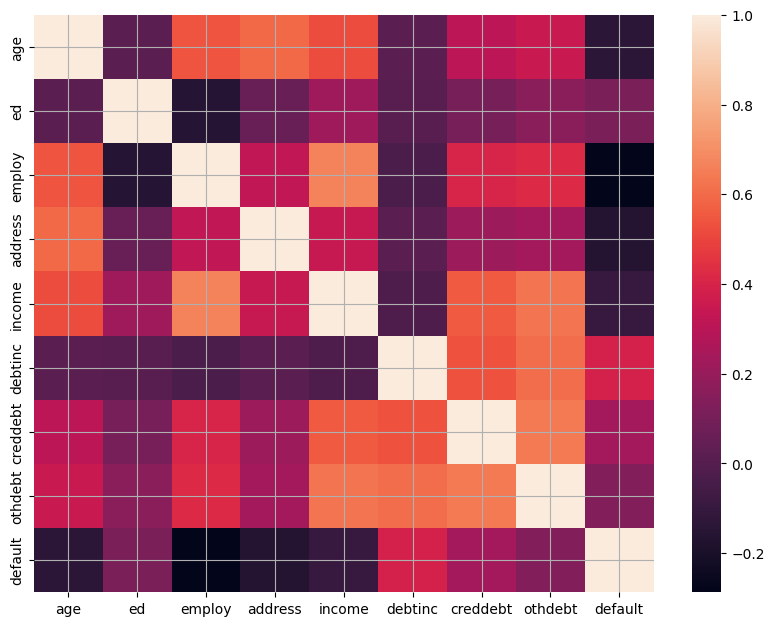

In [12]:
sns.heatmap(bankloans_existing.corr())

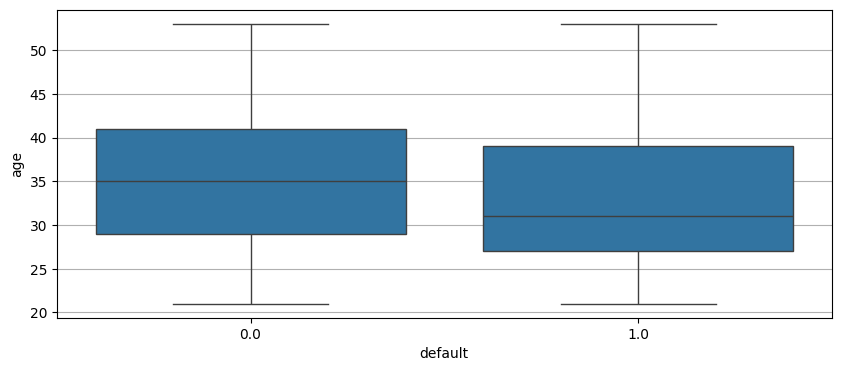

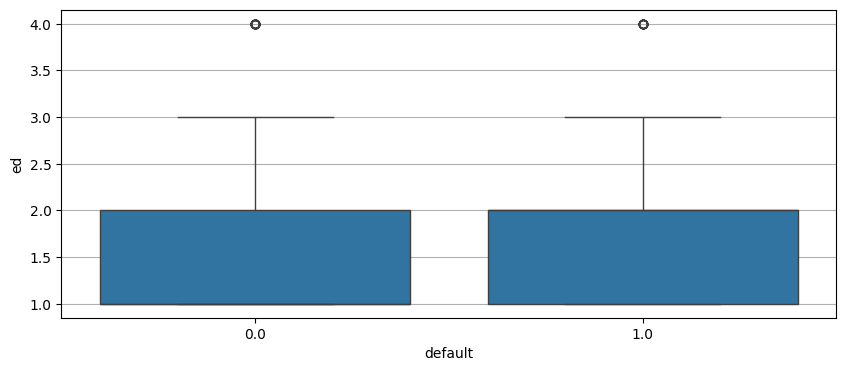

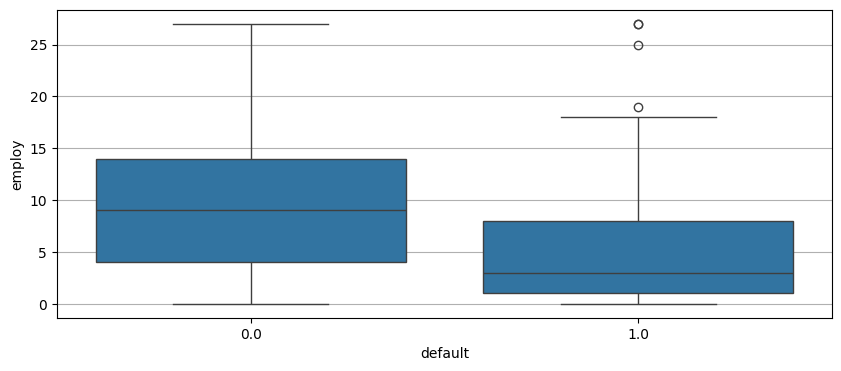

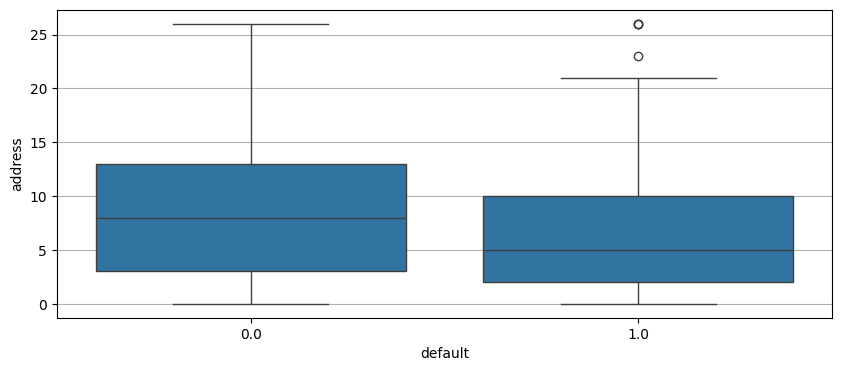

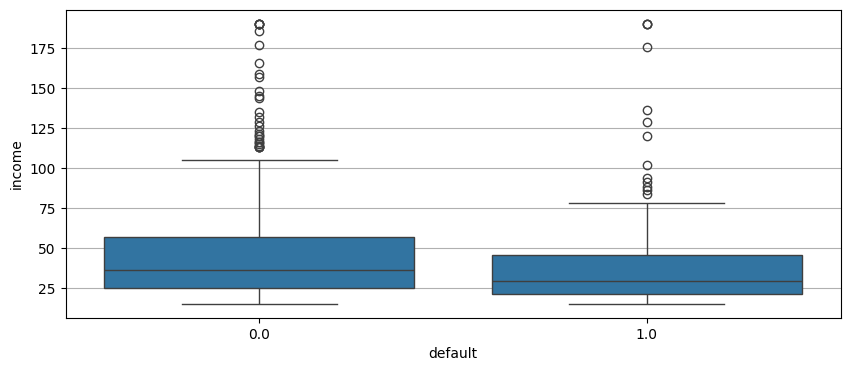

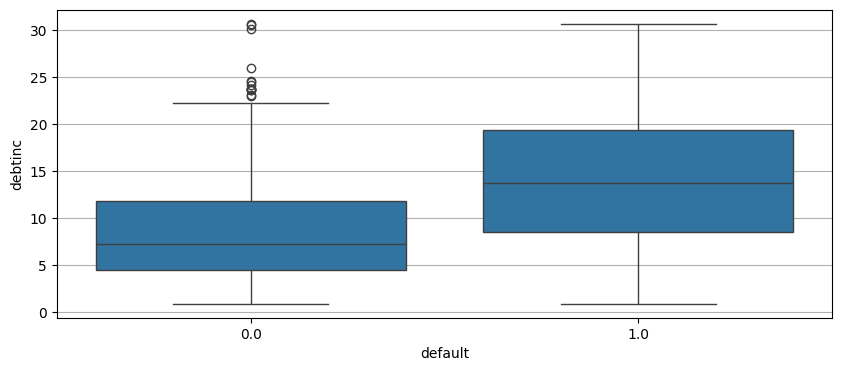

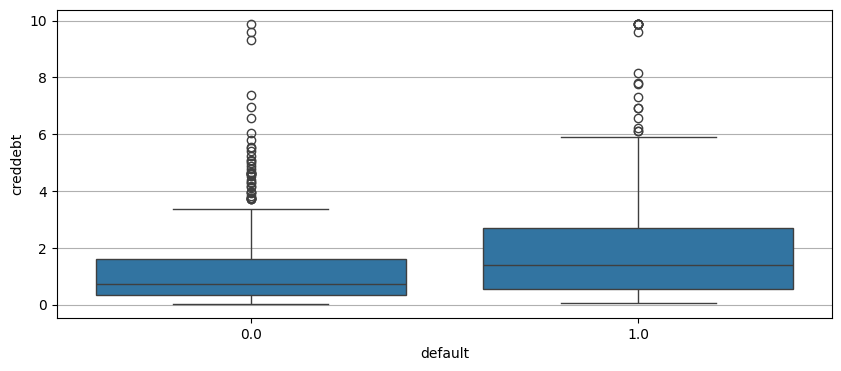

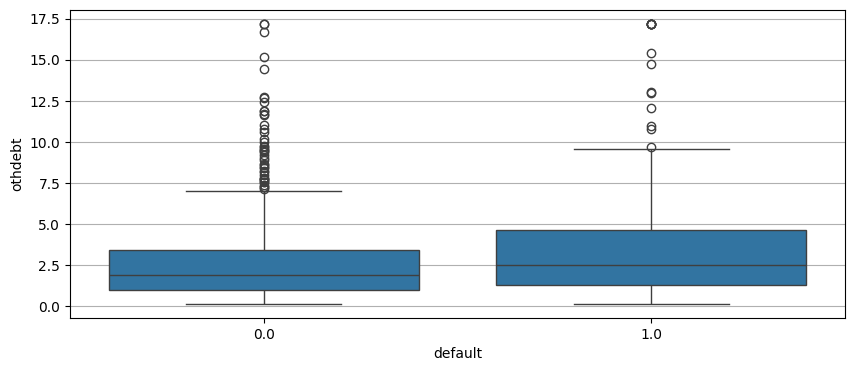

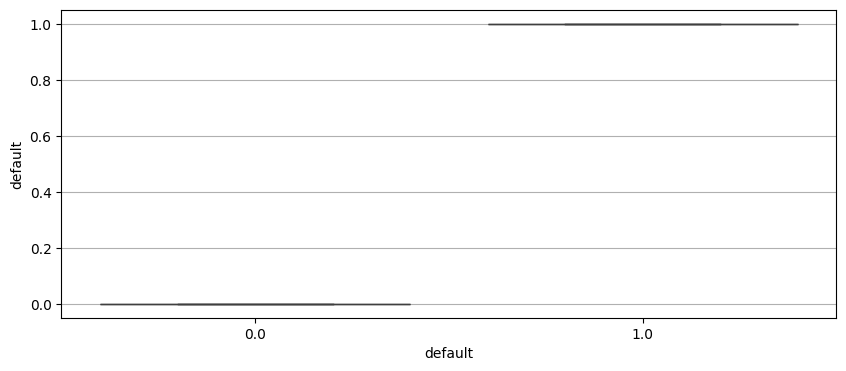

In [13]:
bp = PdfPages('BoxPlots with default Split.pdf')

for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(x='default', y=num_variable, data = bankloans_existing)
    bp.savefig(fig)
bp.close()

In [14]:
tstats_df = pd.DataFrame()
for num_variable in bankloans_existing.columns.difference(['default']):
    tstats=stats.ttest_ind(bankloans_existing[bankloans_existing.default==1][num_variable],bankloans_existing[bankloans_existing.default==0][num_variable])
    temp = pd.DataFrame([num_variable, tstats[0], tstats[1]]).T
    temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']
    tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)
print(tstats_df)

  Variable Name   T-Statistic      P-Value
0       address -4.4305517189 0.0000109104
1           age -3.6989325593 0.0002335268
2      creddebt  6.4790870198 0.0000000002
3       debtinc 11.1409356971 0.0000000000
4            ed  3.1535069955 0.0016823602
5        employ -7.9213575753 0.0000000000
6        income -2.6432918978 0.0083946797
7       othdebt  3.7072967386 0.0002260946


C:\Users\HP\AppData\Local\Temp\ipykernel_13196\1511063791.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bankloans_existing[bankloans_existing['default']==0][num_variable], label='Not Default', color='b', hist=True, norm_hist=False)
C:\Users\HP\AppData\Local\Temp\ipykernel_13196\1511063791.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwask

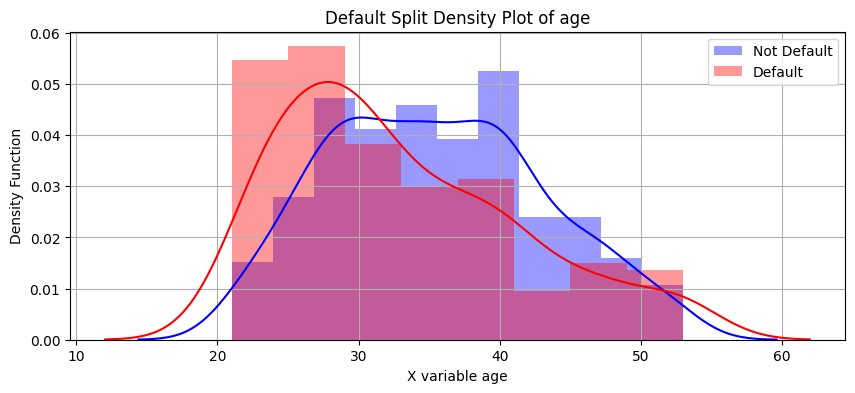

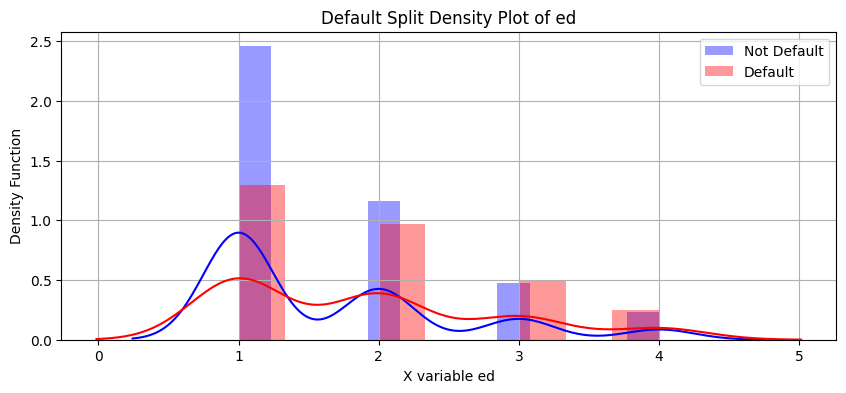

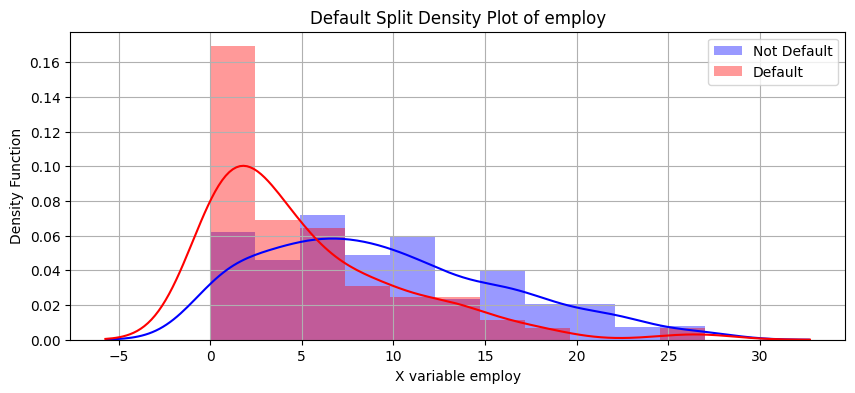

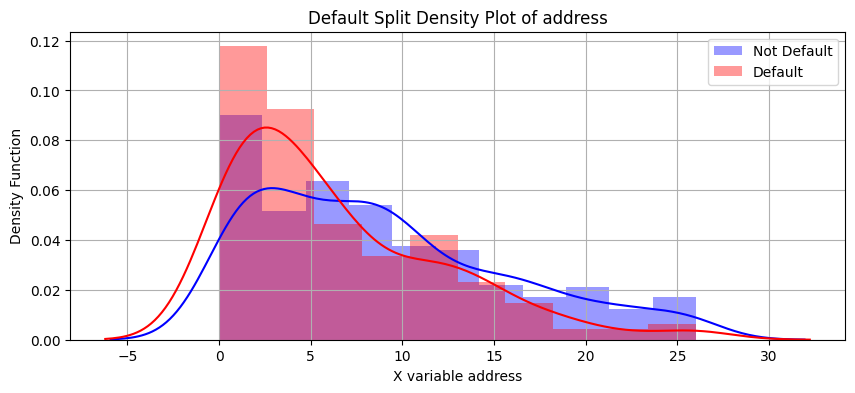

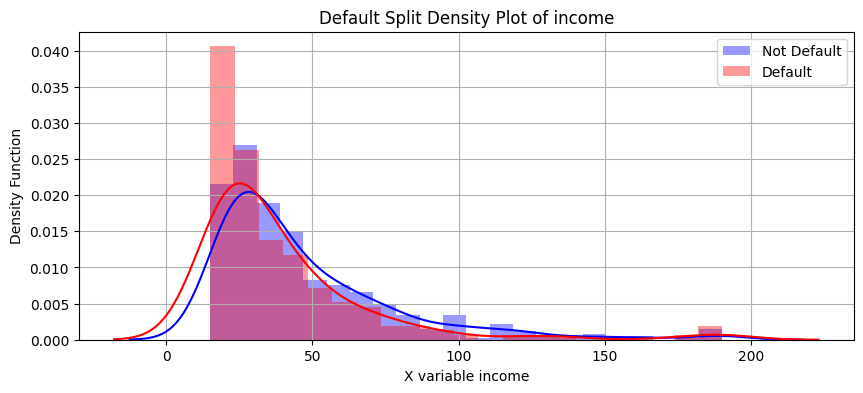

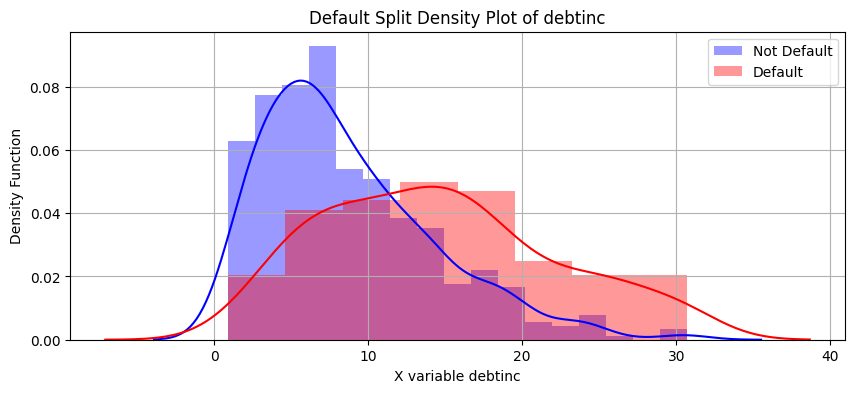

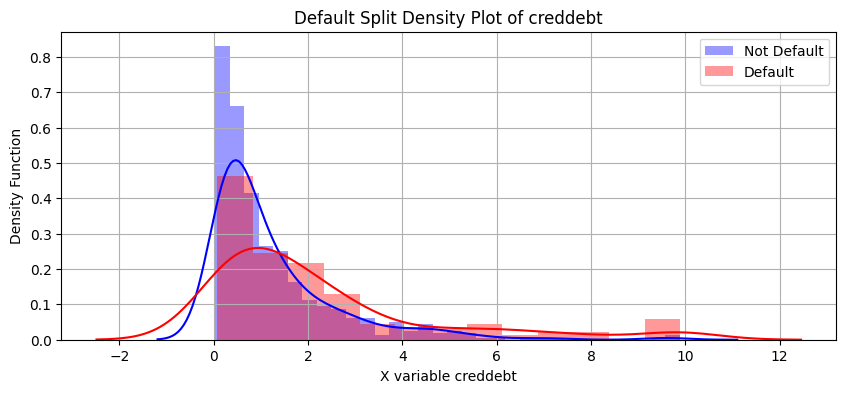

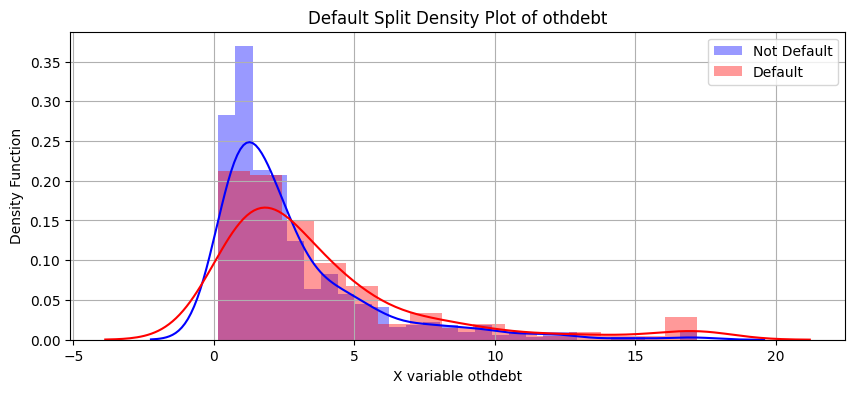

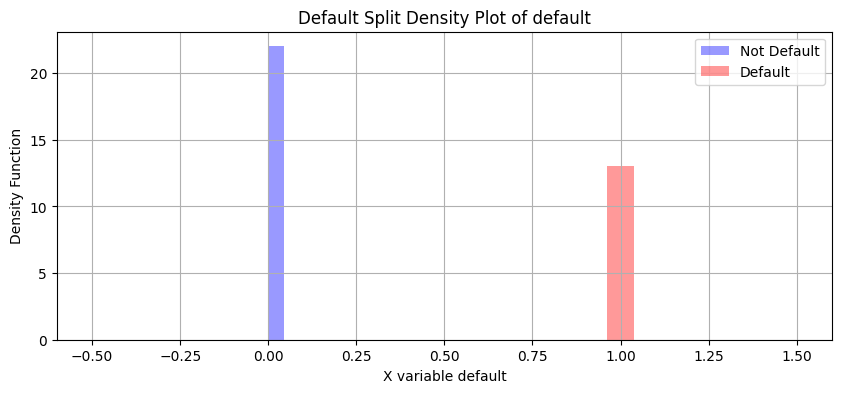

In [15]:
for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))

#sns.distplot(hrdf[num_variable], kde=False, color='g', hist=True)
    sns.distplot(bankloans_existing[bankloans_existing['default']==0][num_variable], label='Not Default', color='b', hist=True, norm_hist=False)
    sns.distplot(bankloans_existing[bankloans_existing['default']==1][num_variable], label='Default', color='r', hist=True, norm_hist=False)
    plt.xlabel(str("X variable ") + str(num_variable) )
    plt.ylabel('Density Function')
    plt.title(str('Default Split Density Plot of ')+str(num_variable))
    plt.legend()

C:\Users\HP\AppData\Local\Temp\ipykernel_13196\3232217652.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ser = bankloans_existing.groupby(binned)['default'].sum() / (bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
C:\Users\HP\AppData\Local\Temp\ipykernel_13196\3232217652.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ser = bankloans_existing.groupby(binned)['default'].sum() / (bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
C:\Users\HP\AppData\Local\Temp\ipykernel_13196\3232217652.py

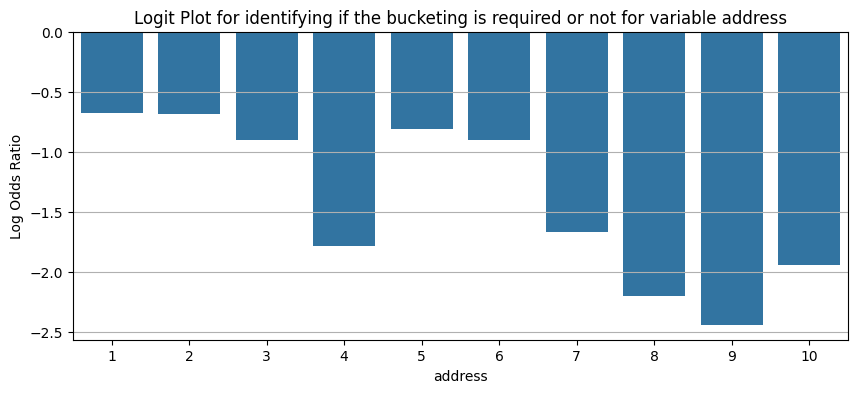

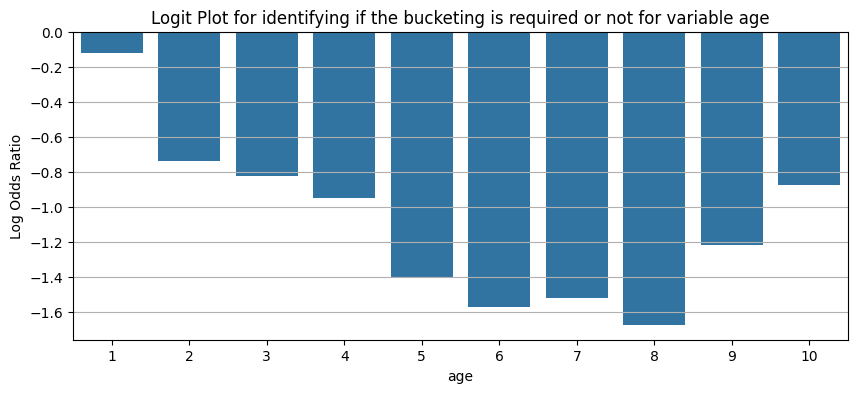

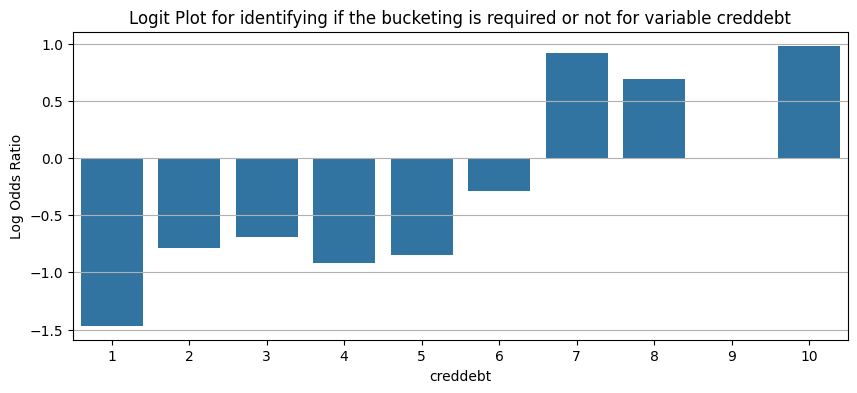

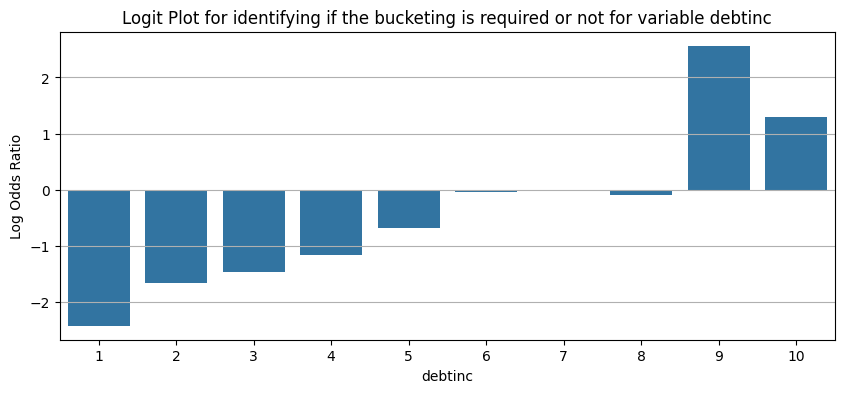

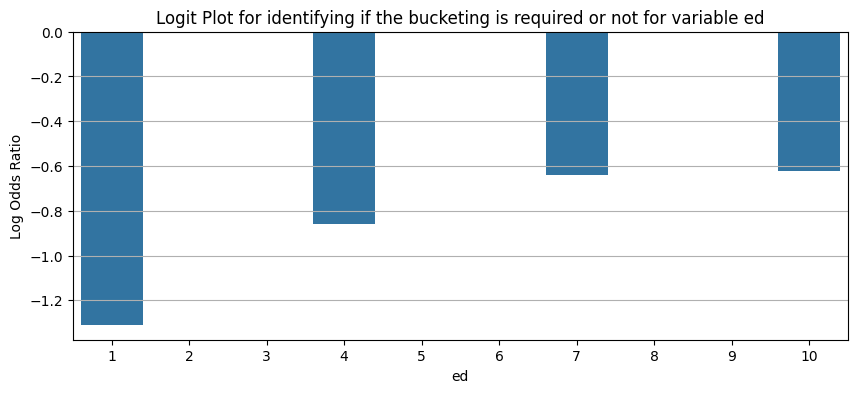

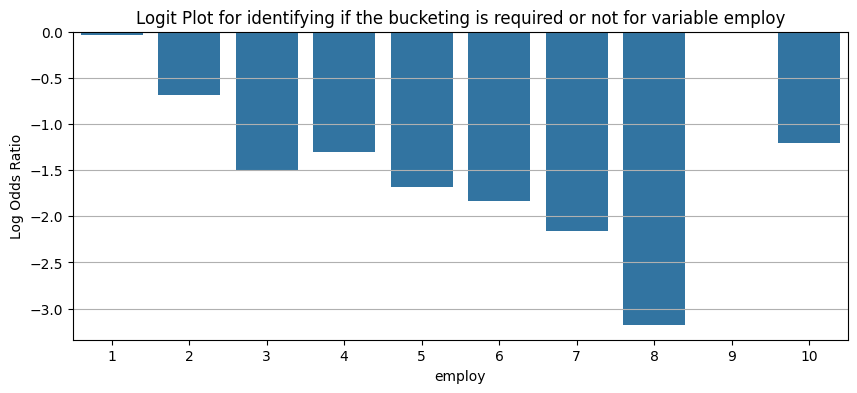

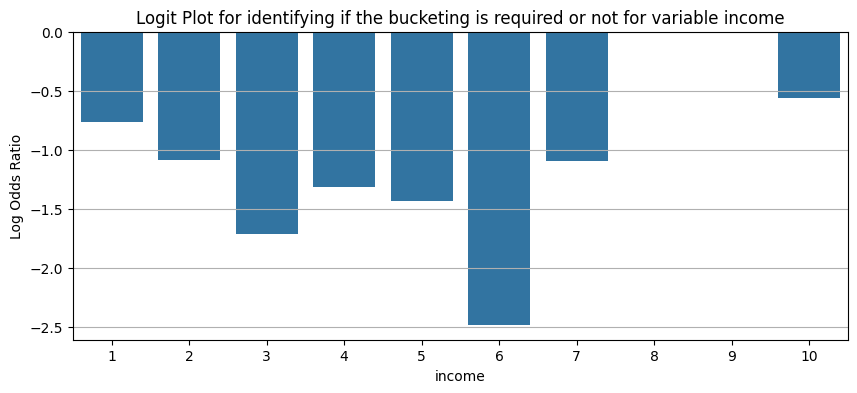

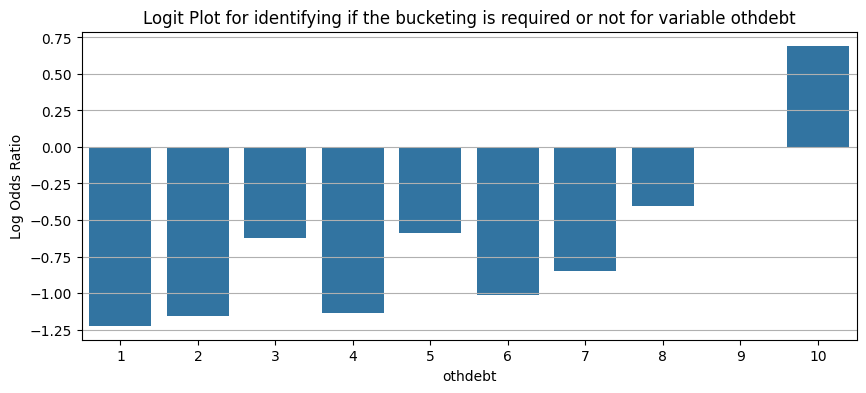

In [16]:
bp = PdfPages('Transformation Plots.pdf')

for num_variable in bankloans_existing.columns.difference(['default']):
    binned = pd.cut(bankloans_existing[num_variable], bins=10, labels=list(range(1,11)))
    binned = binned.dropna()
    ser = bankloans_existing.groupby(binned)['default'].sum() / (bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
    ser = np.log(ser)
    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=ser.index,y=ser)
    plt.ylabel('Log Odds Ratio')
    plt.title(str('Logit Plot for identifying if the bucketing is required or not for variable ') + str(num_variable))
    bp.savefig(fig)

bp.close()

In [17]:
print('These variables need bucketing - creddebt, othdebt, debtinc, employ, income ')
bankloans_existing.columns

These variables need bucketing - creddebt, othdebt, debtinc, employ, income 


Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [18]:
bankloans_existing[['creddebt', 'othdebt', 'debtinc', 'employ','income' ]].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
creddebt,700.0000000000,1.4988430492,1.7884505826,0.0302088600,0.1700198000,0.3013896000,0.4404176000,0.5930592000,0.8548695000,1.1834712000,1.6150232000,2.2880256000,3.6215040000,9.8914279200
othdebt,700.0000000000,3.0272903979,3.1154009614,0.1609361700,0.5622318000,0.9007472000,1.1657664000,1.5461008000,1.9875675000,2.5110540000,3.2587772000,4.5779256000,7.0361802000,17.1847444800
debtinc,700.0000000000,10.2221528571,6.6821601241,0.9000000000,2.9000000000,4.5000000000,5.8000000000,7.0000000000,8.6000000000,10.5000000000,12.9000000000,15.4400000000,19.6100000000,30.7010000000
employ,700.0000000000,8.3586714286,6.5660078678,0.0000000000,1.0000000000,2.0000000000,4.0000000000,5.6000000000,7.0000000000,9.0000000000,11.0000000000,14.0000000000,18.0000000000,27.0100000000
income,700.0000000000,44.8487142857,31.9421331409,15.0000000000,19.0000000000,22.0000000000,26.0000000000,29.0000000000,34.0000000000,40.4000000000,49.0000000000,61.0000000000,82.0000000000,190.3000000000


In [19]:
features = "+".join(bankloans_existing.columns.difference(['default']))
a,b = dmatrices(formula_like='default ~ '+ features, data = bankloans_existing, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

     VIF Factor   features
0 36.9109868428  Intercept
1  1.5618021108    address
2  2.0375928326        age
3  2.6288987970   creddebt
4  3.9105092384    debtinc
5  1.2873453795         ed
6  2.4015438011     employ
7  5.1215854286     income
8  4.5620720803    othdebt


In [20]:
train_features = bankloans_existing.columns.difference(['default'])
train_X, test_X = train_test_split(bankloans_existing, test_size=0.3, random_state=42)
train_X.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [21]:
logreg = sm.logit(formula='default ~ ' + "+".join(train_features), data=train_X)
result = logreg.fit()
summ = result.summary()
summ

Optimization terminated successfully.
         Current function value: 0.425391
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  490
Model:                          Logit   Df Residuals:                      481
Method:                           MLE   Df Model:                            8
Date:                Sat, 17 Feb 2024   Pseudo R-squ.:                  0.2749
Time:                        11:51:16   Log-Likelihood:                -208.44
converged:                       True   LL-Null:                       -287.47
Covariance Type:            nonrobust   LLR p-value:                 4.065e-30
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3844      0.736     -1.881      0.060      -2.827       0.058
address       -0.0853      0.026     -3.306      0.001      -0.136      -0.035
age            0.0389      0.020      1.924      0.054      -0.001       0.078
creddebt       0.6410      0.139      4.628      0.000       0.370       0.912
debtinc        0.0353      0.039      0.907      0.365      -0.041       0.112
ed             0.0080      0.142      0.056      0.955      -0.271       0.287
employ        -0.2650      0.040     -6.641      0.000      -0.343      -0.187
income        -0.0089      0.012     -0.721      0.471      -0.033       0.015
othdebt        0.1249      0.102      1.226      0.220      -0.075       0.325
==============================================================================
"""

In [22]:
AUC = metrics.roc_auc_score(train_X['default'], result.predict(train_X))

print('AUC is -> ' + str(AUC))

AUC is -> 0.8408309575716921


In [23]:
train_gini = 2*metrics.roc_auc_score(train_X['default'], result.predict(train_X)) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X['default'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.6816619151433843
The Gini Index for the model built on the Test Data is :  0.7665103308404106


In [24]:
train_predicted_prob = pd.DataFrame(result.predict(train_X))
train_predicted_prob.columns = ['prob']
train_actual = train_X['default']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']

test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']

## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
def cut_off_calculation(result,train_X,train_predict):
    
    roc_like_df = pd.DataFrame()
    train_temp = train_predict.copy()

    for cut_off in np.linspace(0,1,50):
        train_temp['cut_off'] = cut_off
        train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
        train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
        train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
        sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
        specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
        roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
        roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
        roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)
    return roc_like_df

roc_like_df = cut_off_calculation(result,train_X,train_predict)

In [25]:
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.2244897959,0.8805970149,0.6601123596,1.5407093745


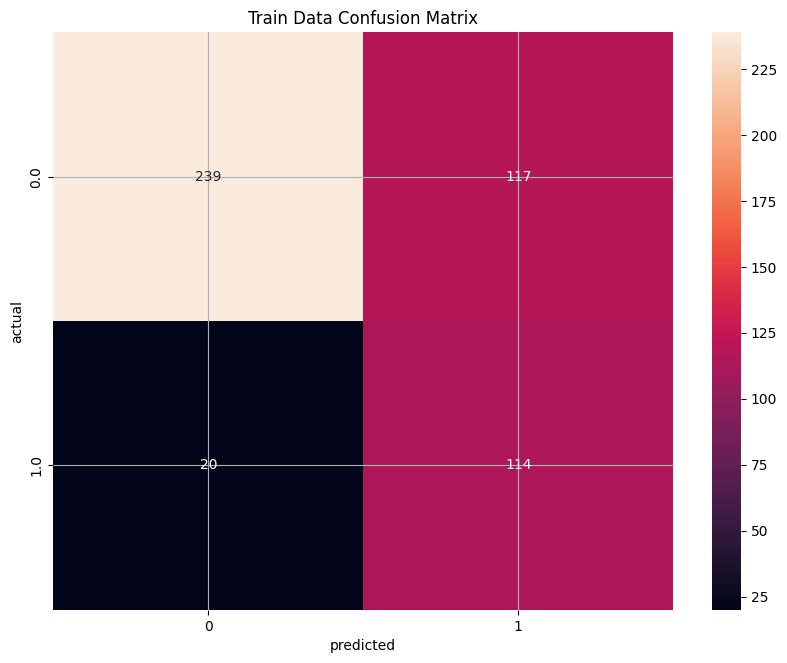

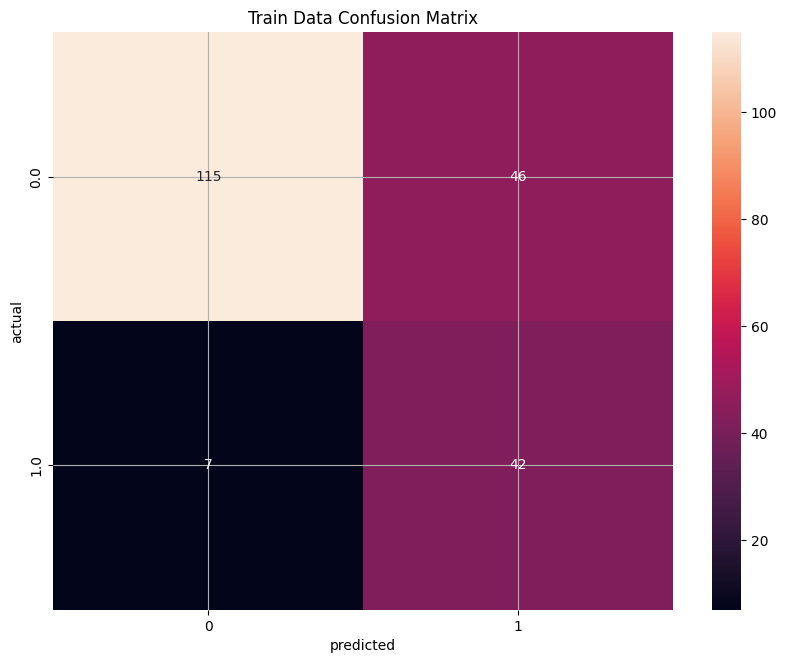

In [26]:
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.24 else 0)
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()

test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.24 else 0)
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()

In [27]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.7204081632653061
The overall accuracy score for the Test Data  is :  0.7476190476190476


In [28]:
train_predict['Deciles']=pd.qcut(train_predict['prob'],10, labels=False)
#test['Deciles']=pd.qcut(test['prob'],10, labels=False)
train_predict.head()

,actual,prob,predicted,Deciles
357,1.0000000000,0.5737083838,1,8
649,0.0000000000,0.5000301976,1,8
291,0.0000000000,0.0600395547,0,2
420,1.0000000000,0.5748237708,1,8
177,0.0000000000,0.1327312293,0,3


In [29]:
df = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).sum().sort_index(ascending=False)

In [30]:
df

,Deciles,actual
Deciles,,
9,441,36.0000000000
8,392,28.0000000000
7,343,26.0000000000
6,294,15.0000000000
5,245,13.0000000000
4,196,6.0000000000
3,147,5.0000000000
2,98,3.0000000000
1,49,2.0000000000


In [31]:
train_features = bankloans_existing.columns.difference(['default'])
train_sk_X,test_sk_X, train_sk_Y ,test_sk_Y = train_test_split(bankloans_existing[train_features],bankloans_existing['default'], test_size=0.3, random_state=42)
train_sk_X.columns

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt'],
      dtype='object')

In [32]:
logisticRegr = LogisticRegression()
logisticRegr.fit(train_sk_X, train_sk_Y)

LogisticRegression()

In [33]:
#Predicting the test cases
train_pred = pd.DataFrame({'actual':train_sk_Y,'predicted':logisticRegr.predict(train_sk_X)})
train_pred = train_pred.reset_index()
train_pred.drop(labels='index',axis=1,inplace=True)

In [34]:
train_gini = 2*metrics.roc_auc_score(train_sk_Y, logisticRegr.predict(train_sk_X)) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_sk_Y, result.predict(test_sk_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.3830706020459498
The Gini Index for the model built on the Test Data is :  0.7665103308404106


In [35]:
predict_proba_df = pd.DataFrame(logisticRegr.predict_proba(train_sk_X))
hr_test_pred = pd.concat([train_pred,predict_proba_df],axis=1)
hr_test_pred.columns=['actual','predicted','Left_0','Left_1']

In [36]:
auc_score = metrics.roc_auc_score( hr_test_pred.actual, hr_test_pred.Left_1  )
round( float( auc_score ), 2 )

0.84

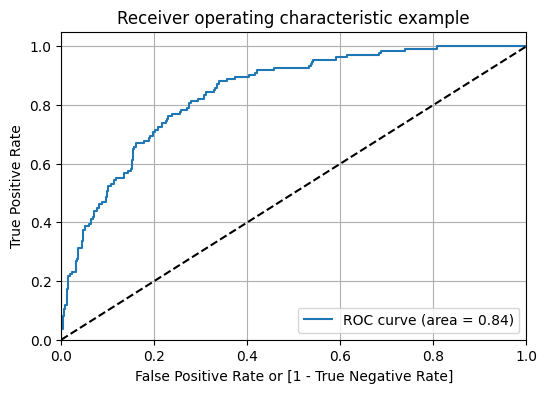

In [37]:
fpr, tpr, thresholds = metrics.roc_curve( hr_test_pred.actual,hr_test_pred.Left_1,drop_intermediate=False )
plt.figure(figsize=(6, 4))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [38]:
cutoff_prob = thresholds[(np.abs(tpr - 0.72)).argmin()]

In [39]:
cutoff_prob

0.37244980478169815

In [40]:
hr_test_pred['new_labels'] = hr_test_pred['Left_1'].map( lambda x: 1 if x >= 0.36 else 0 )

In [41]:
print("The overall accuracy score for the Train Data is : ", round(metrics.accuracy_score(train_sk_Y, logisticRegr.predict(train_sk_X)),2))
print("The overall accuracy score for the Test Data is : ", round(metrics.accuracy_score(test_sk_Y, logisticRegr.predict(test_sk_X)),2))

The overall accuracy score for the Train Data is :  0.79
The overall accuracy score for the Test Data is :  0.86


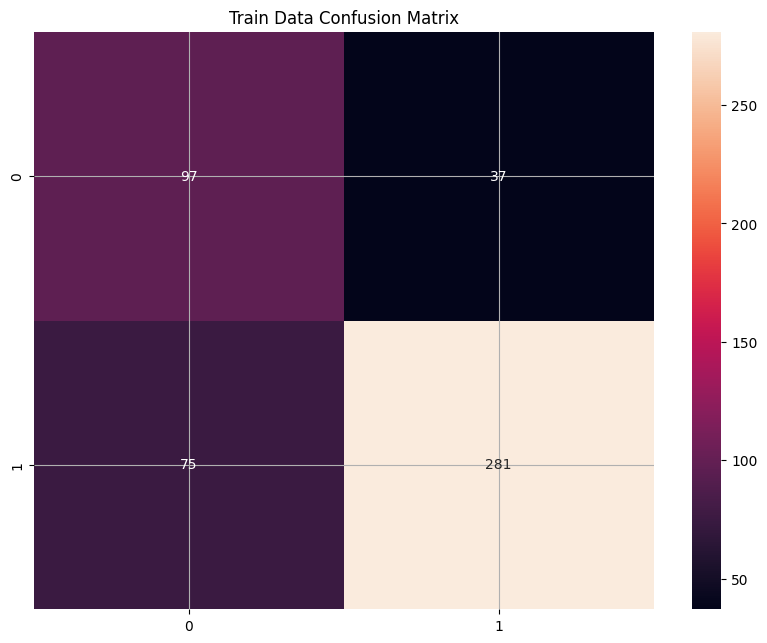

In [46]:
# Creating a confusion matrix

from sklearn import metrics

cm_train = metrics.confusion_matrix(y_true=hr_test_pred['actual'], y_pred=hr_test_pred['new_labels'], labels=[1,0])

sns.heatmap(cm_train,annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()

In [54]:
new_data = pd.read_csv(r'C:\xampp\htdocs\TaskMS\credit\credit_analysis_data2.csv')
new_data.drop(['name' ],axis=1,inplace=True)
new_data.head()

,age,ed,employ,address,income,debtinc,creddebt,othdebt,default
0,12,1,3,5,500,6,1,1,1


In [56]:
predicted_probabilities = result.predict(new_data)
predicted_probabilities=predicted_probabilities*100
print(predicted_probabilities)

0   0.3750515677
dtype: float64
